# Electric Production

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pmd
from pmdarima import auto_arima

from dateutil.easter import easter

from timeseries_utils import (
    timeseries_csv_to_df,
    split_train_test,
    plot_results
)

warnings.filterwarnings("ignore")

Our first dataset will be reflecting the evolution of the production of electric and gas utilities in the United States. We will start our analysis by importing the data and taking a look at some of its main descriptors.

In [2]:
electric_df = timeseries_csv_to_df("../data/Electric_Production.csv", timeseries_format="%m/%d/%Y")

With the dataset loaded, is important to divide it into train and test sets to avoid the Data Snooping Bias since the very beggining:

In [3]:
train_electric, test_electric = split_train_test(electric_df)

### Dataset Description 

In [4]:
train_electric.describe()

,IPG2211A2N
count,317.000000
mean,85.346568
std,14.579603
min,55.315100
25%,73.847100
50%,86.300000
75%,95.207500
max,119.488000


In [5]:
print(f"The minimum date of the dataset is {train_electric.index.min()} and the max is {train_electric.index.max()}.")

The minimum date of the dataset is 1985-01-01 00:00:00 and the max is 2011-05-01 00:00:00.


As a second step, we may now take a look at what the dataset actually looks like:

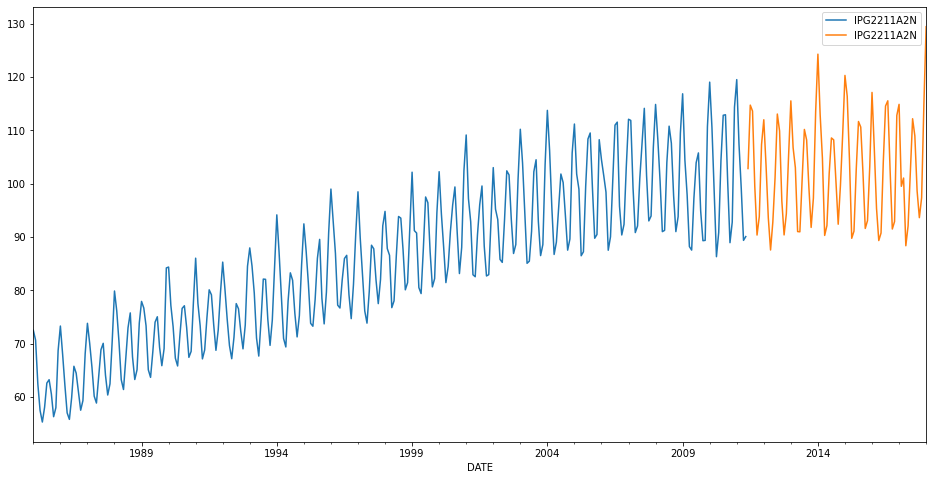

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
train_electric.plot(ax=ax)
test_electric.plot(ax=ax)
plt.show()

We perceive that the data is not stationary, as it presents an upwards trend until 2006 approximately, and several fluctuations which could be indeed to stationality. Nevertheless, to be more sure about our observations we may plot the ACF and the PACF and check its results:

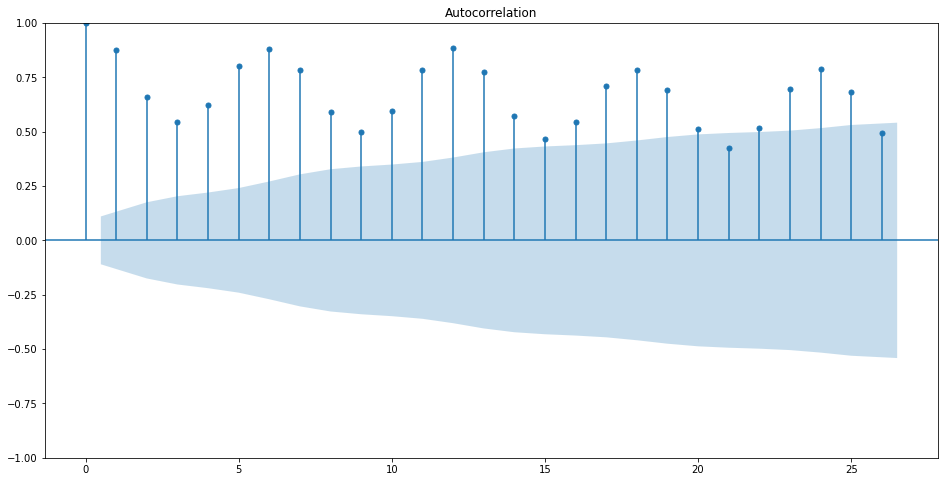

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
_ = plot_acf(train_electric, ax=ax)

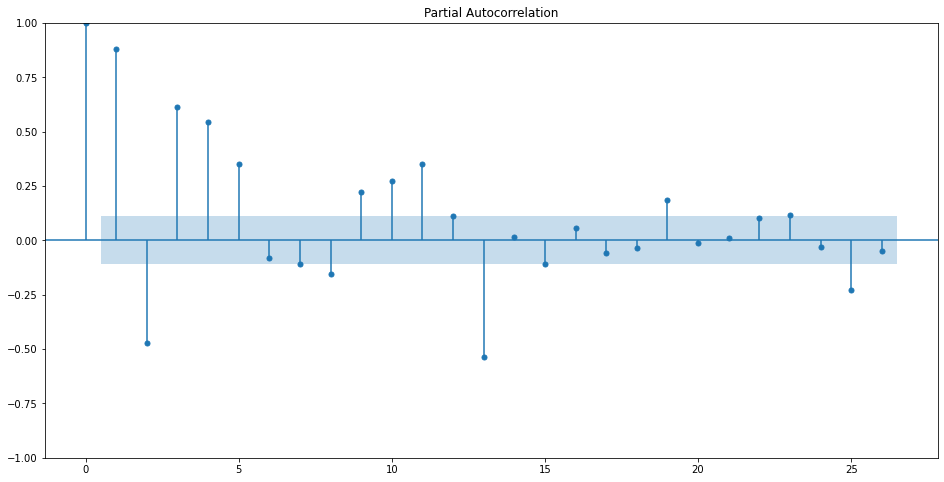

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
_ = plot_pacf(train_electric, ax=ax)

As we can see, the ACF shows a cyclic behaviour, with up and downs between the 0.5 and 1 values, whilst the PACF decreases rapidly after the 2nd term, to go up again and replicate some of the cyclic behaviour observed before. Now, what we can do to further study this timeseries is to plot the seasonal decomposition:

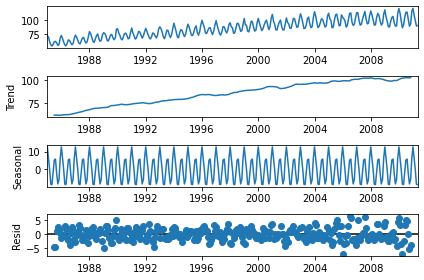

In [9]:
decompose = seasonal_decompose(train_electric)
_ = decompose.plot()

As we observed on our first plot, this dataset seem to have an upwards trend until 2006 approximately, while the seasonal factor is present accross every year present on the data. Thus, we can confirm that the dataset is not stationary, although we could also perform the Augmented Dickery-Fuller (ADF) test and observe the results to be sure:

In [10]:
adf = adfuller(train_electric)
adf

(-1.7386950117875195,
 0.4112939344557718,
 15,
 301,
 {'1%': -3.452263435801039,
  '5%': -2.871190526189069,
  '10%': -2.571911967527952},
 1401.7831544268493)

And now we are clear, as the null hypothesis of the ADF test is rejected due to a p-value of more than 0.18, and we should treat our data as stationary.

### Data Transformations

To deal with the stationarity presented in our dataset we are going to perform a differencing of degree 3 and thus try to make the dataset stationary:

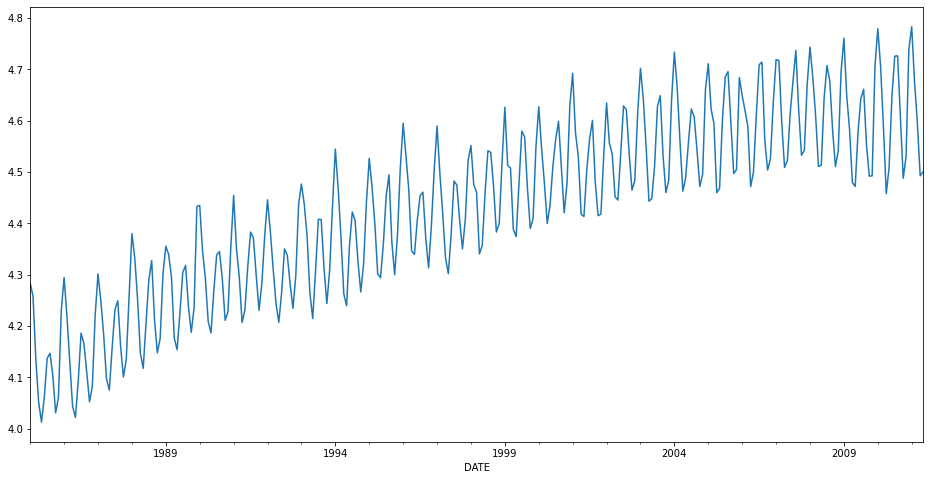

In [11]:
train_electric_log = np.log(train_electric["IPG2211A2N"])
train_electric_log.plot(figsize=(16, 8))
plt.show()

In [12]:
adf = adfuller(train_electric_log)
adf

(-2.583215275072468,
 0.09651618737111978,
 15,
 301,
 {'1%': -3.452263435801039,
  '5%': -2.871190526189069,
  '10%': -2.571911967527952},
 -1306.8105934307398)

### Modelling

Now that we've adequated our dataset to be stationary we may start performing the modelling needed to forecast the results:

#### Exponential Smoothing

In [15]:
model = ExponentialSmoothing(
    train_electric_log.values,
    trend='add',
    seasonal='add',
    seasonal_periods=3,
).fit()

prediction = pd.DataFrame(model.forecast(len(test_electric)), index=test_electric.index)
prediction.columns = ["IPG2211A2N"]
prediction = np.exp(prediction)

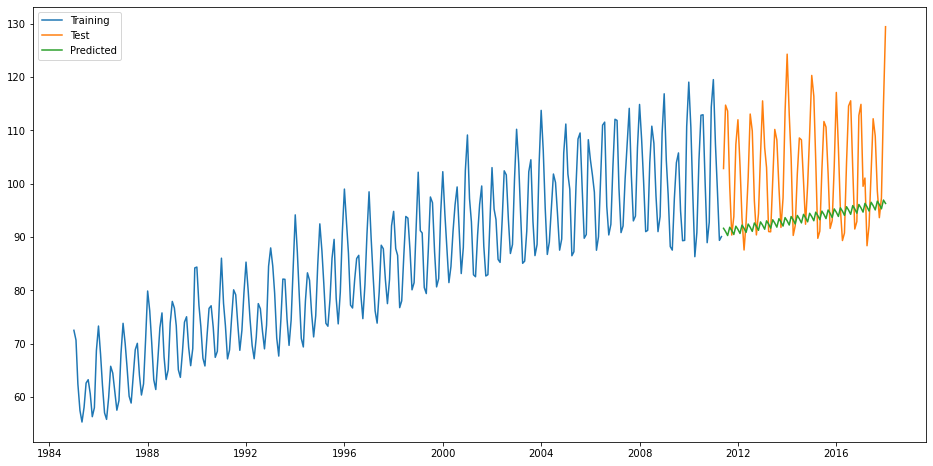

In [16]:
plot_results(train_electric, test_electric, prediction)

#### AutoArima

In [17]:
model = auto_arima(train_electric_log)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  317
Model:               SARIMAX(5, 1, 5)   Log Likelihood                 617.534
Date:                Sat, 13 Nov 2021   AIC                          -1213.069
Time:                        20:38:46   BIC                          -1171.756
Sample:                             0   HQIC                         -1196.564
                                - 317                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3304      0.361      0.915      0.360      -0.377       1.038
ar.L2          0.2085      0.352      0.592      0.554      -0.481       0.898
ar.L3         -0.6537      0.207     -3.151      0.002      -1.060      -0.247
ar.L4         -0.0119      0.229     -0.052      0.959      -0.461       0.438
ar.L5          0.5518      0.207      2.672      0.008       0.147       0.957
ma.L1         -0.4744      0.367     -1.291      0.197      -1.195       0.246
ma.L2         -0.4049      0.416     -0.972      0.331      -1.221       0.411
ma.L3          0.7620      0.165      4.624      0.000       0.439       1.085
ma.L4         -0.1448      0.296     -0.490      0.624      -0.724       0.435
ma.L5         -0.5937      0.293     -2.026      0.043      -1.168      -0.019
sigma2         0.0011   8.73e-05     12.958      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 3.88
Prob(Q):                              0.56   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.14
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
prediction = pd.DataFrame(model.predict(n_periods = len(test_electric)),index=test_electric.index)
prediction.columns = ["IPG2211A2N"]
prediction = np.exp(prediction)

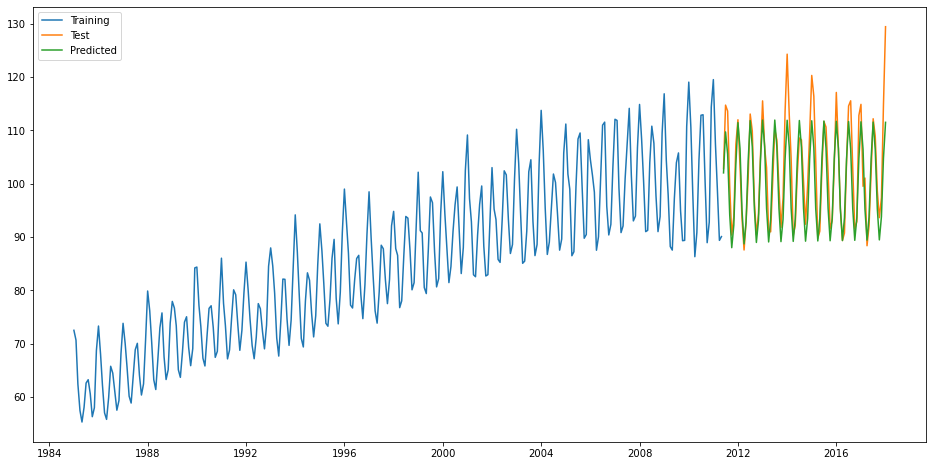

In [19]:
plot_results(train_electric, test_electric, prediction)

The ARIMA model seems more or less accurate, but it fails to detect the extremely good values, as its trend tends to be more conservative and thus it generates quite a big error on those observations. Nevertheless, it performs quite well in comparison with the Exponential model which understimated both the trend and the seasonality of the time series.